In [6]:
""" This code is only for demonstration purpose"""
""" The part of the code for the actual generation of the noise 
has referenced heavily Hunter Gabbard's corresponding  """

""" Only the function "noisegenerator" is responsible for making the noise"""


import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, interpolate, signal, optimize, stats
import pyfftw

In [1]:
def ASDtxt(x):
    """This function reads the following noise curves given a detector name."""
    return {
        'H1': './ASD/ligoII_NS.txt',
    }[x]


In [2]:
def readnos(detector, f_points):
    """This function reads amplitude sprectral density given a txt file."""
    nos_file = ASDtxt(detector)
    f_str = []
    ASD_str = []
    file = open(nos_file, 'r')
    readFile = file.readlines()
    file.close()
    f = []
    ASD = []
    
    for line in readFile:
        p = line.split()
        f_str.append(float(p[0]))
        ASD_str.append(float(p[1]))
    f = np.log10(np.array(f_str))
    ASD = np.log10(np.array(ASD_str))
    nosinterpolate = interpolate.splrep(f, ASD, w=1.0*np.ones(len(ASD)), s=0)
    
    nos = interpolate.splev(np.log10(f_points), nosinterpolate, der = 0, ext = 3)
    nos = 10**nos
    
    return nos

In [39]:
def noisegenerator(Tobs, det, SR, df, dt):
    """This function generates noise based on amplitude spectral density"""
    
    # The number of time stamps
    Ns = Tobs * SR 
    
    # The number of the frequency samples
    Nf = int(Ns // 2 + 1)
    
    # The frequency sample
    fs = np.arange(Nf) * df
    
    # read ASD
    ASD = readnos(det, fs)

    PSD = ASD ** 2
    
    # scale the ASD by the observation time, and this will be the highest amplitude of the generated noise
    Amp = np.sqrt(Tobs * PSD)
    
    real_nos = Amp * np.random.normal(0.0, 1.0, Nf)
    img_nos = Amp * np.random.normal(0.0, 1.0, Nf)
    
    
        
        
    # to ensure no strange barviour from low frequency     
    low_cutoff = 20
    
    idx_1 =  int(low_cutoff/df)
    real_nos[0:idx_1] = 0
    img_nos[0:idx_1] = 0
    
    
    
    nos = real_nos + 1j * img_nos
    
    # whiten, perform inverse Fourier transiform, and converts the generated noise to the time domain
    fftinput = pyfftw.empty_aligned(len(nos), dtype='complex128')
    fft_object = pyfftw.builders.irfft(fftinput)
    nos_realization = Ns* fft_object(nos / ASD) * df
    
    return ASD, nos_realization, nos, fs
    

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


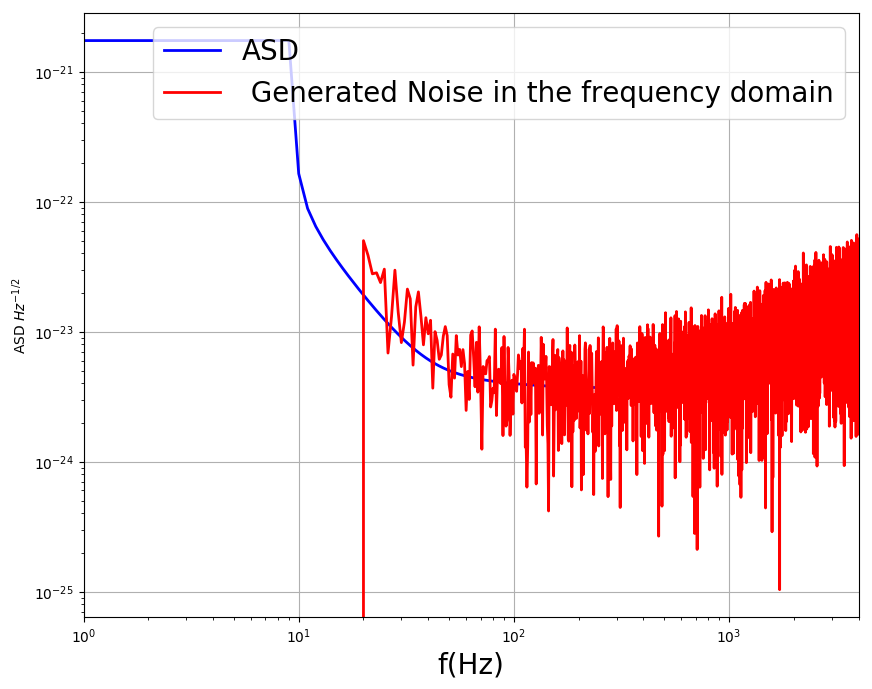

In [46]:
Tobs = 1.0              #observation time
SR = 8192               #sampling rate
dt = 1.0/SR             #time interval between samples
df = 1.0/(Tobs)         #frequency interval
N = Tobs * SR           #number of sample in the time domain
ts = np.arange(N) * dt  # time samples 


asd, ns, nos, fs = noisegenerator(Tobs, 'H1', SR, df, dt)

fig=plt.figure(figsize=(10, 8), dpi= 100, facecolor='w', edgecolor='k')
plt.loglog(fs, asd, linewidth = 2, color = 'b', label = 'ASD')
plt.loglog(fs, abs(nos), linewidth = 2, color = 'r', label = ' Generated Noise in the frequency domain')
plt.legend(loc ='upper right', fontsize=  fontsize)
plt.grid()
plt.xlim([1, 4000])
fontsize = 20
plt.xlabel('f(Hz)', fontsize = fontsize)
plt.ylabel(r'ASD $Hz^{-1/2}$')
plt.show()


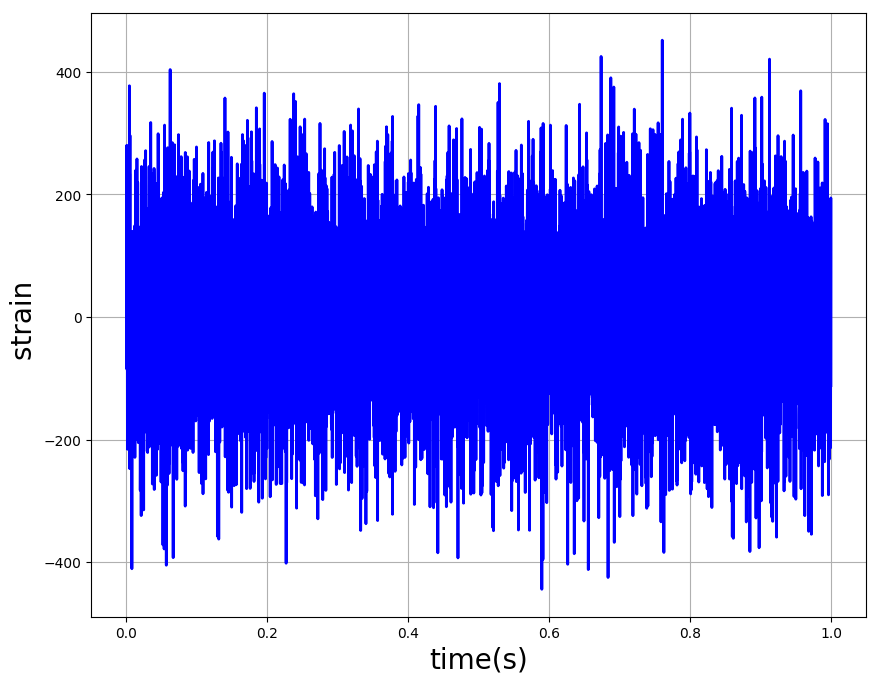

In [47]:
fig=plt.figure(figsize=(10, 8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(ts, ns, linewidth = 2, color = 'b')
plt.grid()

fontsize = 20
plt.xlabel('time(s)', fontsize = fontsize)
plt.ylabel(r'strain ', fontsize = fontsize)
plt.show()
